In [51]:
import pandas as pd
pd.options.plotting.backend = 'plotly'
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from scipy.stats import skew
from sklearn.preprocessing import QuantileTransformer

#Recomended: Control dpi
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150
pd.options.display.max_columns = None

Let's start by importing the dataset we created in the previous analysis.

In [13]:
df = pd.read_csv('dataset_model.csv')
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,has_long_call,has_neg_balance
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0.0,unknown,no,0,0
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0.0,unknown,no,0,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0.0,unknown,no,0,0
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0.0,unknown,no,0,0
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0.0,unknown,no,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40685,25,technician,single,secondary,no,505,no,yes,cellular,17,nov,386,2,-1,0.0,unknown,yes,0,0
40686,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0.0,unknown,yes,1,0
40687,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0.0,unknown,yes,0,0
40688,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3.0,success,yes,1,0


## Pre-processing 
### Feature Skewness 

Many models make assumptions about the features being normally distributed, so transforming our features into more normal features can boost our predictive ability. Let's check the skewness of our data. We will analyze the continuous variables in our dataset (age,balance, and duration). 

Skewness for age: 0.6834969593546876
Skewness for duration: 3.1389673232473143
Skewness for balance: 8.410197357516967


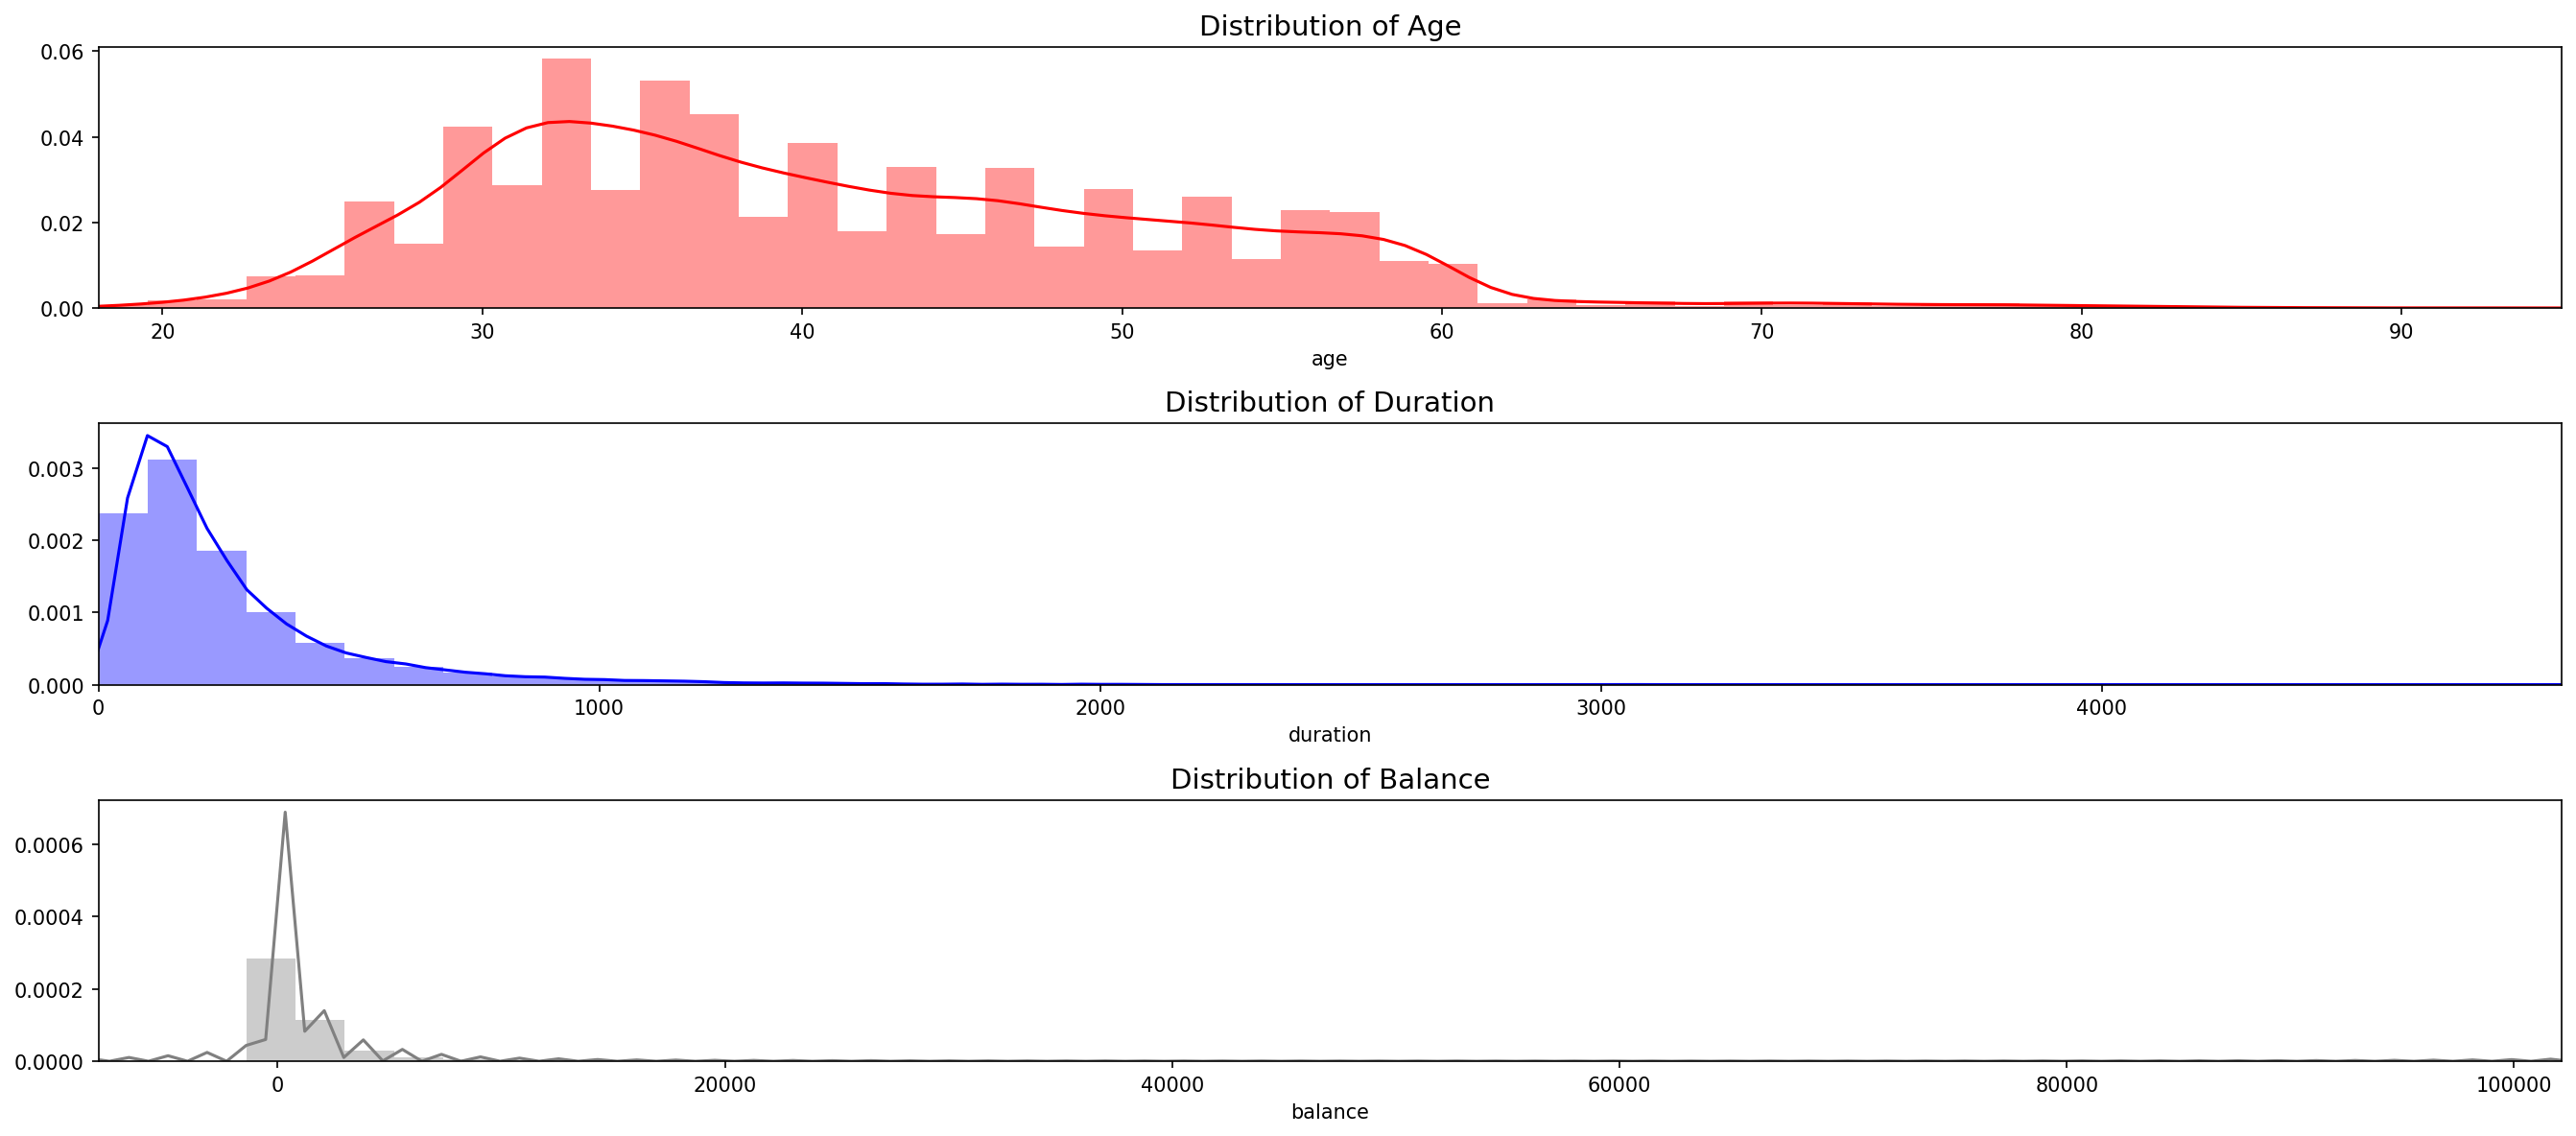

In [39]:
from scipy.stats import shapiro
fig, ax = plt.subplots(3, 1, figsize=(18, 8))

sns.distplot(df['age'], ax=ax[0], color='r')
ax[0].set_title('Distribution of Age', fontsize=14)
ax[0].set_xlim([min(df['age']), max(df['age'])])
print('Skewness for age: ' + str(df['age'].skew()))

sns.distplot(df['duration'], ax=ax[1], color='b')
ax[1].set_title('Distribution of Duration', fontsize=14)
ax[1].set_xlim([min(df['duration']), max(df['duration'])])
print('Skewness for duration: ' + str(df['duration'].skew()))

sns.distplot(df['balance'], ax=ax[2], color='gray')
ax[2].set_title('Distribution of Balance', fontsize=14)
ax[2].set_xlim([min(df['balance']), max(df['balance'])])
print('Skewness for balance: ' + str(df['balance'].skew()))

plt.tight_layout()

The values for asymmetry and kurtosis between -2 and +2 are considered acceptable in order to prove normal univariate distribution (George & Mallery, 2010).

Skewness for age: 0.6834969593546876
Skewness for duration: 1.172708625300734
Skewness for balance: 0.004881272692783332


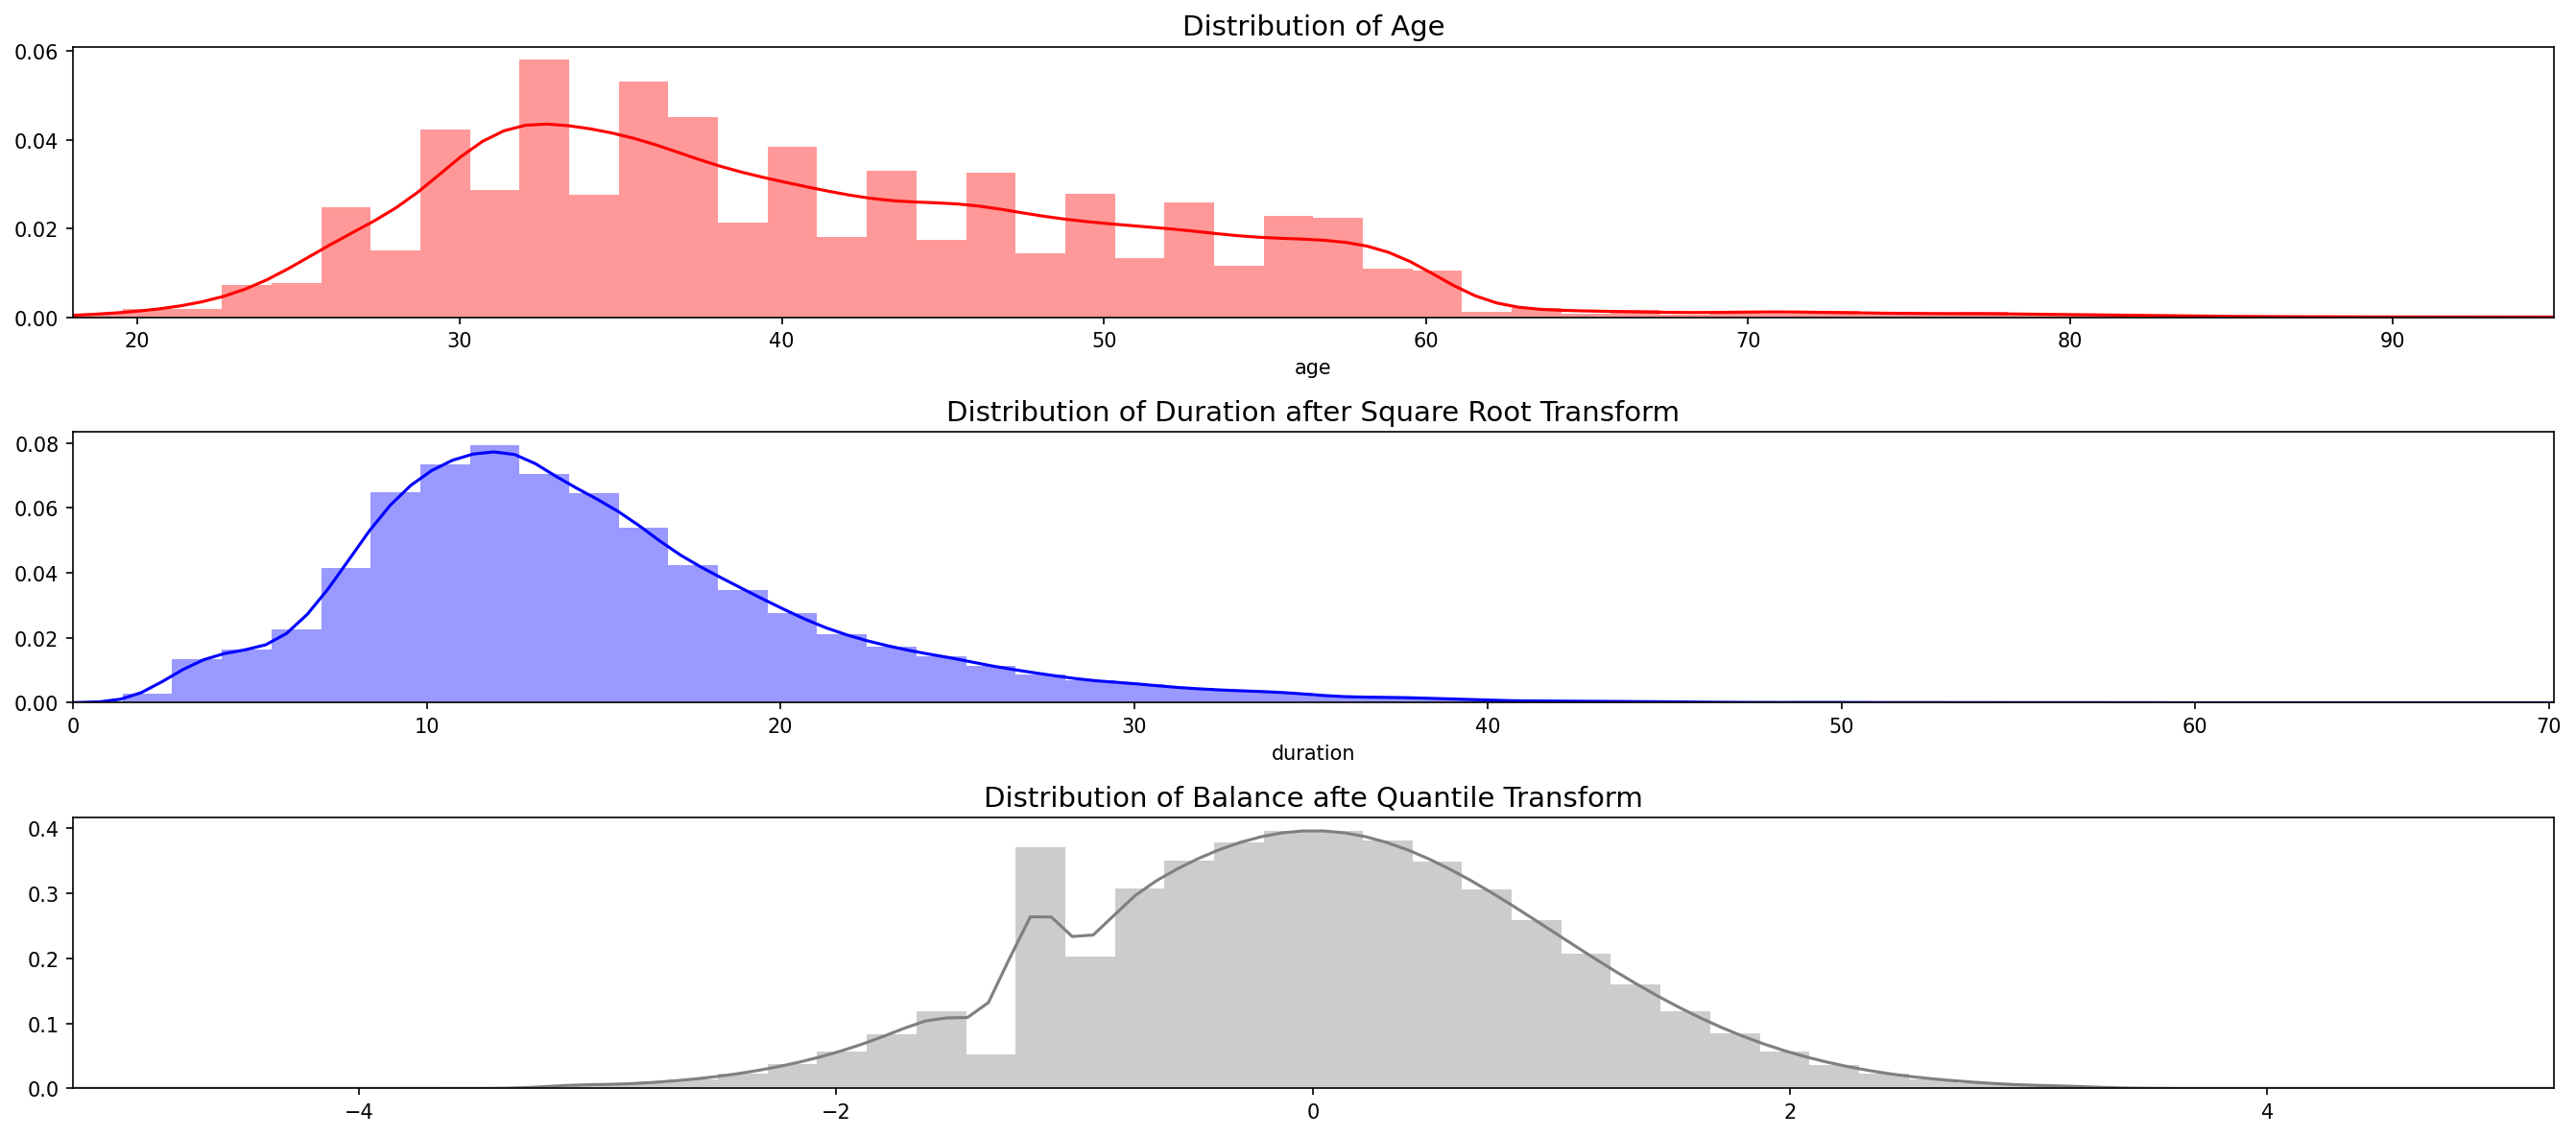

In [15]:
fig, ax = plt.subplots(3, 1, figsize=(18, 8))

age = df['age']
duration = np.sqrt(df['duration'])
balance_var = df['balance'].values
balance = QuantileTransformer(output_distribution='normal').fit_transform(
    balance_var.reshape(-1, 1))

sns.distplot(age, ax=ax[0], color='r')
ax[0].set_title('Distribution of Age', fontsize=14)
ax[0].set_xlim([min(age), max(age)])
print('Skewness for age: ' + str(age.skew()))

sns.distplot(duration, ax=ax[1], color='b')
ax[1].set_title('Distribution of Duration after Square Root Transform',
                fontsize=14)
ax[1].set_xlim([min(duration), max(duration)])
print('Skewness for duration: ' + str(duration.skew()))

sns.distplot(balance, ax=ax[2], color='gray')
ax[2].set_title('Distribution of Balance afte Quantile Transform', fontsize=14)
ax[2].set_xlim([min(balance), max(balance)])
print('Skewness for balance: ' + str(skew(balance)[0]))
plt.tight_layout()

We applied a square root transform to out ```duration``` feature and for our ```balance``` a quantile tranform. We can verify that in general we were able to get a lower skewness for both of the features. For age, we didn't transform this feature because it already has low skewness. Now let's add the transformations to the dataset.

In [16]:
df_model = df.copy()
df_model['duration'] = duration
df_model['balance'] = balance

### Adjusting Cyclical Features

Since ```month``` is a cyclical feature, let's represent it as (x,y) coordinates of a circle.  We compute the x- and y- component of that point using sin and cos trigonometric functions.

Source: http://blog.davidkaleko.com/feature-engineering-cyclical-features.html

In [17]:
# convert into integer
df_model['month'] = pd.to_datetime(df_model.month, format='%b').dt.month
#calculate sin and cos
df_model['mnth_sin'] = np.sin((df_model.month - 1) * (2. * np.pi / 12))
df_model['mnth_cos'] = np.cos((df_model.month - 1) * (2. * np.pi / 12))
#drop month column
df_model = df_model.drop(['month'], axis=1)

Let's apply One hot encoding to prepare our data 

In [18]:
#convert to binary
df_model['loan'] = df_model['loan'].map({'yes': 1, 'no': 0})
df_model['default'] = df_model['default'].map({'yes': 1, 'no': 0})
df_model['housing'] = df_model['housing'].map({'yes': 1, 'no': 0})
df_model['y'] = df_model['y'].map({'yes': 1, 'no': 0})

#One hot encoding
df_model = pd.get_dummies(
    df_model, columns=['job', 'marital', 'education', 'contact', 'poutcome'])
df_model

,age,default,balance,housing,loan,day,duration,campaign,pdays,previous,y,has_long_call,has_neg_balance,mnth_sin,mnth_cos,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown,contact_cellular,contact_telephone,contact_unknown,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,58,0,0.929484,1,0,5,16.155494,1,-1,0.0,0,0,0,0.866025,-0.5,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1
1,44,0,-0.816150,1,0,5,12.288206,1,-1,0.0,0,0,0,0.866025,-0.5,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1
2,33,0,-0.967422,1,1,5,8.717798,1,-1,0.0,0,0,0,0.866025,-0.5,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1
3,47,0,0.707319,1,0,5,9.591663,1,-1,0.0,0,0,0,0.866025,-0.5,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1
4,33,0,-0.983573,0,0,5,14.071247,1,-1,0.0,0,0,0,0.866025,-0.5,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40685,25,0,0.061513,0,1,17,19.646883,2,-1,0.0,1,0,0,-0.866025,0.5,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,1
40686,51,0,0.342823,0,0,17,31.256999,3,-1,0.0,1,1,0,-0.866025,0.5,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1
40687,71,0,0.794461,0,0,17,21.354157,2,-1,0.0,1,0,0,-0.866025,0.5,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1
40688,72,0,1.638729,0,0,17,33.570821,5,184,3.0,1,1,0,-0.866025,0.5,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0


### Split Data

In [19]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline

X = df_model.drop('y', axis=1)
y = df_model['y']

original_Xtrain, original_Xtest, original_ytrain, original_ytest = train_test_split(
    X, y, test_size=0.2, random_state=1, stratify=y)

original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

## Modelling
This section will be the first step in our modelling part of the project. We'll apply 2 different approaches: Applying oversampling with SMOTE and balancing the classes with ```class_weight```. Both of the approaches will be compared to our baseline model, a decision tree model.
### 1 - Baseline Model: Decison Tree

Since our data is imbalanced, the metrics we will try to improve are recall and F1. A good recall, in our case, means that we are able to predict well most of the clients who will accept the offer

In [23]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report


def baseline():
    # List to append the score and then find the average
    accuracy_lst = []
    precision_lst = []
    recall_lst = []
    f1_lst = []
    auc_lst = []

    params = {
        "max_depth": np.random.randint(1, (len(X.columns) * .85), 20),
        "max_features": np.random.randint(3, len(X.columns), 20),
        "min_samples_leaf": [2, 3, 4, 5, 6],
        "criterion": ["gini", "entropy"],
    }
    model_grid_baseline = RandomizedSearchCV(DecisionTreeClassifier(),
                                             params,
                                             n_iter=10,
                                             cv=5,
                                             n_jobs=-1)

    for train, test in sss.split(original_Xtrain, original_ytrain):
        pipeline = imbalanced_make_pipeline(model_grid_baseline)
        model = pipeline.fit(original_Xtrain[train], original_ytrain[train])
        best_est_baseline = model_grid_baseline.best_estimator_
        prediction = best_est_baseline.predict(original_Xtrain[test])

        accuracy_lst.append(
            pipeline.score(original_Xtrain[test], original_ytrain[test]))
        precision_lst.append(precision_score(original_ytrain[test],
                                             prediction))
        recall_lst.append(recall_score(original_ytrain[test], prediction))
        f1_lst.append(f1_score(original_ytrain[test], prediction))
        auc_lst.append(roc_auc_score(original_ytrain[test], prediction))

    print('')
    print("accuracy: {}".format(np.mean(accuracy_lst)))
    print("precision: {}".format(np.mean(precision_lst)))
    print("recall: {}".format(np.mean(recall_lst)))
    print("f1: {}".format(np.mean(f1_lst)))

    return best_est_baseline


model_baseline = baseline()


accuracy: 0.8982030410075257
precision: 0.6090546201576124
recall: 0.3830287206266319
f1: 0.46856919262688185


We see that our recall is pretty low (38%), while the precision is high. This is due to the imbalance in our data, which is expected.

### 2 - DT with Oversampling 

#### Wrong way of Oversampling
<img src="https://www.marcoaltini.com/uploads/1/3/2/3/13234002/2639934.jpg?401">

A common mistake when oversampling is applying the oversample before the cross validation. The problem of this approach is that at some point the training and validation set contain the same sample, resulting in overfitting and misleading results. 

#### Correct way of Oversampling
<img src="https://www.marcoaltini.com/uploads/1/3/2/3/13234002/9101820.jpg?372">
The right way is shown in the figure above. We need to do the oversampling after the cross validation, in order to avoid using the same data for training and validation. This way we avoid overfitting and get reliable results.

Source: https://www.marcoaltini.com/blog/dealing-with-imbalanced-data-undersampling-oversampling-and-proper-cross-validation

In our oversampling, we will apply the same principle by creating a pipeline inside of the cross validation.

In [25]:
from imblearn.over_sampling import SMOTE

accuracy_lst = []
precision_lst = []
recall_lst = []
f1_lst = []
auc_lst = []

params = {
    "max_depth": np.random.randint(1, (len(X.columns) * .85), 20),
    "max_features": np.random.randint(3, len(X.columns), 20),
    "min_samples_leaf": [2, 3, 4, 5, 6],
    "criterion": ["gini", "entropy"],
}
model_grid = RandomizedSearchCV(DecisionTreeClassifier(),
                                params,
                                n_iter=10,
                                cv=5,
                                n_jobs=-1)

# Implementing SMOTE Technique Cross Validating the right way

for train, test in sss.split(original_Xtrain, original_ytrain):
    # SMOTE happens during Cross Validation not before..
    pipeline = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'),
                                        model_grid)
    model = pipeline.fit(original_Xtrain[train], original_ytrain[train])
    best_est = model_grid.best_estimator_
    prediction = best_est.predict(original_Xtrain[test])

    accuracy_lst.append(
        pipeline.score(original_Xtrain[test], original_ytrain[test]))
    precision_lst.append(precision_score(original_ytrain[test], prediction))
    recall_lst.append(recall_score(original_ytrain[test], prediction))
    f1_lst.append(f1_score(original_ytrain[test], prediction))
    auc_lst.append(roc_auc_score(original_ytrain[test], prediction))

print('')
print("accuracy: {}".format(np.mean(accuracy_lst)))
print("precision: {}".format(np.mean(precision_lst)))
print("recall: {}".format(np.mean(recall_lst)))
print("f1: {}".format(np.mean(f1_lst)))


accuracy: 0.8801412993395793
precision: 0.4896155310644362
recall: 0.47389033942558745
f1: 0.4813526271044686


We notice that after oversampling we have an improvement in the recall from 38% to 47%. The F1 improves as well from 46% to 48%. 

### 3 - DT with ```class_weight```

Now we will apply activate the ```class_weight``` parameter in out DT model. The ```class_weight``` defines each class label and the weighting to apply in the calculation of group purity for splits in the decision tree when fitting the model.

In [27]:
# List to append the score and then find the average
accuracy_lst = []
precision_lst = []
recall_lst = []
f1_lst = []
auc_lst = []

params = {
    "max_depth": np.random.randint(1, (len(X.columns) * .85), 20),
    "max_features": np.random.randint(3, len(X.columns), 20),
    "min_samples_leaf": [2, 3, 4, 5, 6],
    "criterion": ["gini", "entropy"],
}
model_grid = RandomizedSearchCV(
    DecisionTreeClassifier(class_weight='balanced'),
    params,
    n_iter=10,
    cv=5,
    n_jobs=-1)

for train, test in sss.split(original_Xtrain, original_ytrain):
    pipeline = imbalanced_make_pipeline(model_grid)
    model = pipeline.fit(original_Xtrain[train], original_ytrain[train])
    best_est = model_grid.best_estimator_
    prediction = best_est.predict(original_Xtrain[test])

    accuracy_lst.append(
        pipeline.score(original_Xtrain[test], original_ytrain[test]))
    precision_lst.append(precision_score(original_ytrain[test], prediction))
    recall_lst.append(recall_score(original_ytrain[test], prediction))
    f1_lst.append(f1_score(original_ytrain[test], prediction))
    auc_lst.append(roc_auc_score(original_ytrain[test], prediction))

print('')
print("accuracy: {}".format(np.mean(accuracy_lst)))
print("precision: {}".format(np.mean(precision_lst)))
print("recall: {}".format(np.mean(recall_lst)))
print("f1: {}".format(np.mean(f1_lst)))


accuracy: 0.8538473352787589
precision: 0.4178665749101572
recall: 0.6096605744125327
f1: 0.4953256759187653


We can verify that with ```class_weight``` we can improve our recall a lot from 47% to 60% and the F1 from 48% to 49%. We'll activate the ```class_weight``` parameter to balance our final model.

### Finding the Best Model

Now let's use the library pycaret in order to compare the performance of 15 different models at once.

In [28]:
from pycaret.classification import *

model_setup = setup(data=df_model,
                    target='y',
                    session_id=24,
                    silent=True,
                    train_size=0.8)  #0.8 for train

 
Setup Succesfully Completed!


,Description,Value
0,session_id,24
1,Target Type,Binary
2,Label Encoded,None
3,Original Data,"(40690, 41)"
4,Missing Values,False
5,Numeric Features,35
6,Categorical Features,5
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


In [29]:
compare_models(fold=5, sort='F1')  # K-fold cross validation with 5 folds

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,Light Gradient Boosting Machine,0.907100,0.930800,0.476200,0.641800,0.546700,0.496200
1,CatBoost Classifier,0.906700,0.932500,0.464700,0.643300,0.539600,0.489200
2,Linear Discriminant Analysis,0.893100,0.895100,0.497700,0.550500,0.522700,0.462700
3,Gradient Boosting Classifier,0.903700,0.918400,0.398800,0.647300,0.493500,0.443600
4,Decision Tree Classifier,0.874200,0.705300,0.484300,0.466700,0.475300,0.403900
5,Extreme Gradient Boosting,0.903400,0.918500,0.370100,0.659800,0.474000,0.425500
6,Ada Boost Classifier,0.899900,0.903900,0.383200,0.620500,0.473700,0.421800
7,Extra Trees Classifier,0.897400,0.911500,0.376000,0.603100,0.463100,0.409800
8,Naive Bayes,0.815300,0.827600,0.636800,0.345500,0.447800,0.348500
9,Random Forest Classifier,0.896900,0.890800,0.349500,0.607900,0.443700,0.391500


### Final Model

As we saw in the table before, the LightGBM showed the best performance in our dataset, so let's use this model and hypertune it.

In [30]:
import lightgbm as lgb


def lightgbm_model():
    # List to append the score and then find the average
    accuracy_lst = []
    precision_lst = []
    recall_lst = []
    f1_lst = []
    auc_lst = []

    params = {
        'num_leaves': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 150, 200],
        'max_depth': [int(x) for x in np.linspace(10, 110, num=11)],
        'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
        'n_estimators': [10, 30, 50, 70, 90, 100, 120, 150, 170, 200],
        'min_split_gain': [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
        'reg_alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
        'reg_lambda': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    }
    model_grid_final = RandomizedSearchCV(lgb.LGBMClassifier(
        class_weight='balanced', random_state=0),
                                          params,
                                          n_iter=10,
                                          cv=5,
                                          n_jobs=-1)

    for train, test in sss.split(original_Xtrain, original_ytrain):
        pipeline = imbalanced_make_pipeline(model_grid_final)
        model = pipeline.fit(original_Xtrain[train], original_ytrain[train])
        best_est_final = model_grid_final.best_estimator_
        prediction = best_est_final.predict(original_Xtrain[test])

        accuracy_lst.append(
            pipeline.score(original_Xtrain[test], original_ytrain[test]))
        precision_lst.append(precision_score(original_ytrain[test],
                                             prediction))
        recall_lst.append(recall_score(original_ytrain[test], prediction))
        f1_lst.append(f1_score(original_ytrain[test], prediction))
        auc_lst.append(roc_auc_score(original_ytrain[test], prediction))

    print('')
    print("Accuracy: {}".format(np.mean(accuracy_lst)))
    print("Precision: {}".format(np.mean(precision_lst)))
    print("Recall: {}".format(np.mean(recall_lst)))
    print("F1: {}".format(np.mean(f1_lst)))

    return best_est_final


lightgbm_m = lightgbm_model()


Accuracy: 0.8918752879741975
Precision: 0.5316050062179789
Recall: 0.7044386422976502
F1: 0.6049744396032527


The final model had a big improvement if compared with the baseline. Our recall improved from 38% on the baseline to 70% on the final model. The same happened with the F1 score.

### Model Evaluation

Let's evaluate our model performance on the test set.

In [50]:
from sklearn.metrics import classification_report
pd.DataFrame(
    classification_report(original_ytest,
                          lightgbm_m.predict(original_Xtest),
                          output_dict=True)).transpose()  #final model

,precision,recall,f1-score,support
0,0.958467,0.912686,0.935017,7181.000000
1,0.517692,0.703239,0.596367,957.000000
accuracy,0.888056,0.888056,0.888056,0.888056
macro avg,0.738080,0.807963,0.765692,8138.000000
weighted avg,0.906634,0.888056,0.895193,8138.000000


In [32]:
pd.DataFrame(
    classification_report(original_ytest,
                          model_baseline.predict(original_Xtest),
                          output_dict=True)).transpose()  #baseline

,precision,recall,f1-score,support
0,0.928842,0.956134,0.942291,7181.000000
1,0.577748,0.450366,0.506166,957.000000
accuracy,0.896658,0.896658,0.896658,0.896658
macro avg,0.753295,0.703250,0.724228,8138.000000
weighted avg,0.887555,0.896658,0.891004,8138.000000


As we saw before, for class 1 we were able to improve the recall and F1 considerably. 

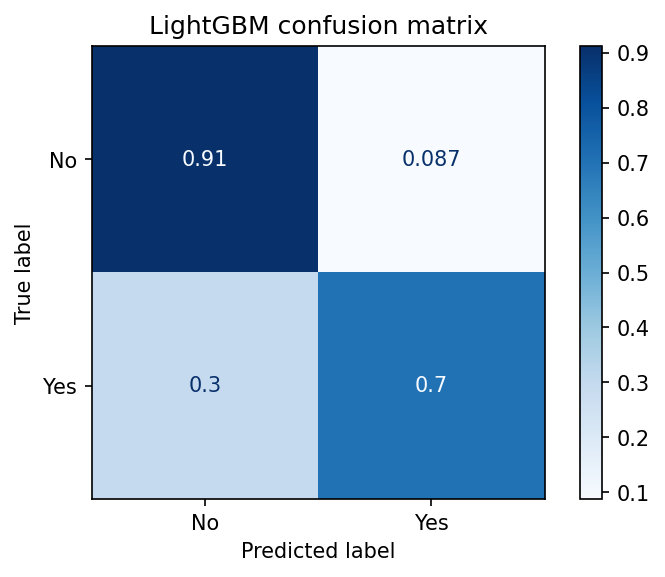

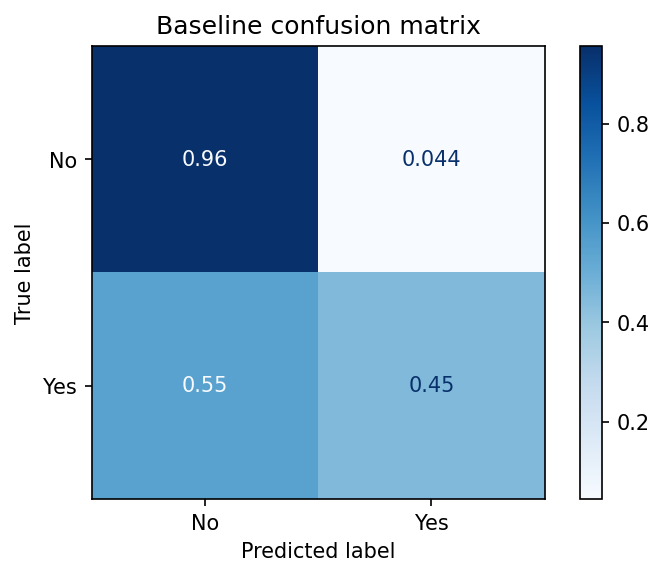

In [33]:
from sklearn.metrics import plot_confusion_matrix

class_names = ['No', 'Yes']
# Plot non-normalized confusion matrix
titles_options = [("LightGBM confusion matrix", 'true', lightgbm_m),
                  ("Baseline confusion matrix", 'true', model_baseline)]
for title, normalize, model in titles_options:
    disp = plot_confusion_matrix(model,
                                 original_Xtest,
                                 original_ytest,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

plt.show()

The confusion matrix for both models shows that we were able to decrease the percentage of false negatives from 55% to 30%. The true positive increased from 45% on the baseline to 70% on our final model. There's still room for improvement, but this model is able to create reasonable predictions.

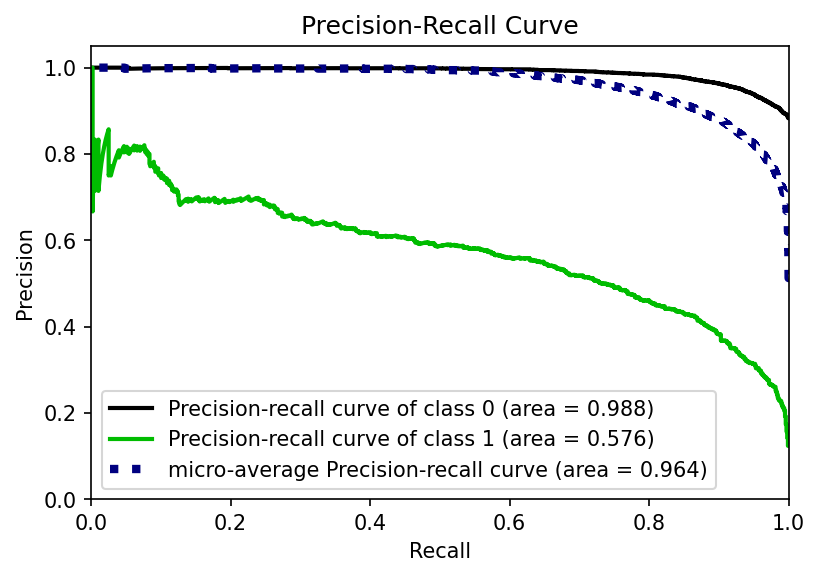

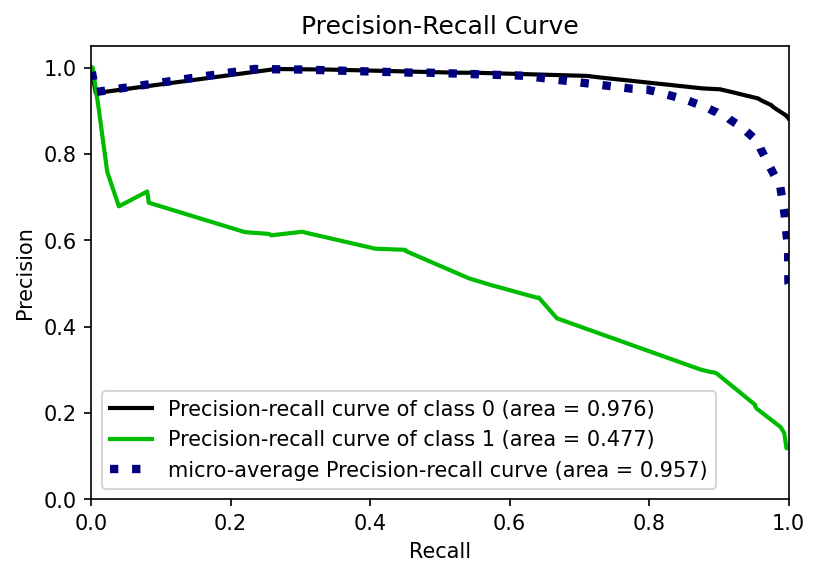

In [34]:
import scikitplot as skplt

skplt.metrics.plot_precision_recall(original_ytest,
                                    lightgbm_m.predict_proba(original_Xtest))
skplt.metrics.plot_precision_recall(
    original_ytest, model_baseline.predict_proba(original_Xtest))

### Model Interpretation

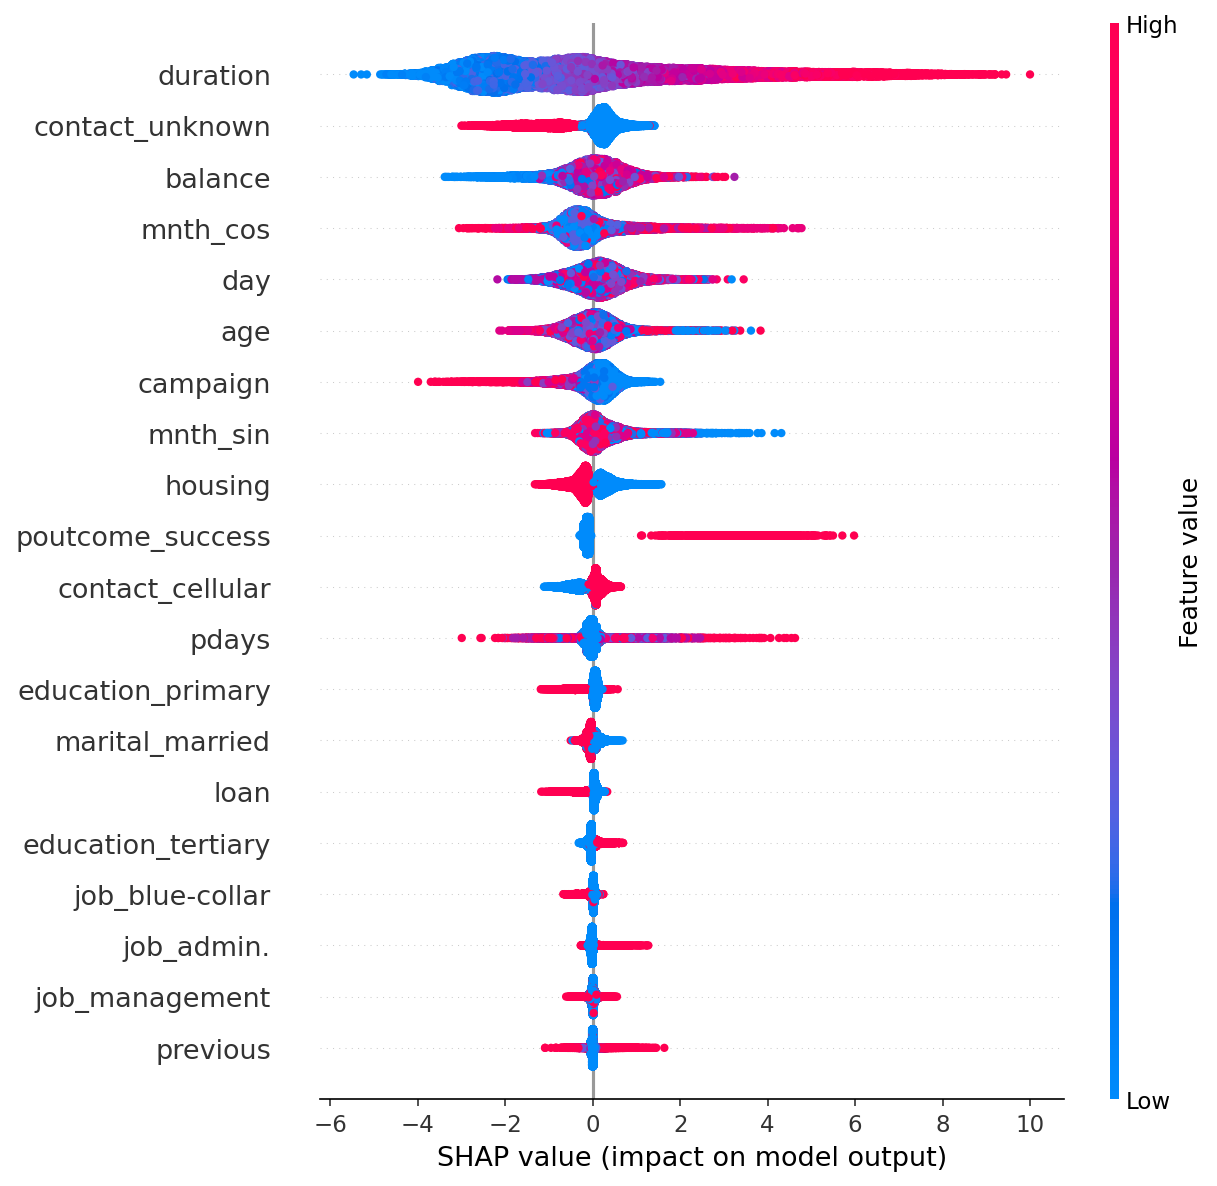

In [40]:
import shap
explainer = shap.TreeExplainer(lightgbm_m)
shap_values = explainer.shap_values(X)

shap.summary_plot(shap_values[1], X, plot_type='dot')

The chart above shows the SHAP values for the model feature. We can interpret it as follows:

* The y-axis indicates the name of the variable, in order of importance from top to bottom. The value next to them is the average SHAP value.
* On the x axis is the SHAP value. From this number, we can extract the probability of success.
* The gradient color indicates the original value for this variable. In Booleans, two colors will be needed, but in continuous features it can contain the entire spectrum.
* Each point represents a row from the original dataset.

We can verify that the most important feature is ```duration```. The longer the call is, the higher is the probability of the client accepting the offer. We also saw this in our EDA.

The type of contact also had a big importance in the model, which is not surprising since we saw that the most of the clients who accepted the offer were contacted from an unknown device.

Balance was the third most important feature for our model. We see that the higher the balance, the more likely the client is to accept the offer.


### Model predictions 

In [53]:
y_pred = lightgbm_m.predict(original_Xtest)
test_df = pd.DataFrame(original_Xtest, columns=[X.columns.values])
test_df['y_pred'] = y_pred
test_df.head(5)

,age,default,balance,housing,loan,day,duration,campaign,pdays,previous,has_long_call,has_neg_balance,mnth_sin,mnth_cos,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown,contact_cellular,contact_telephone,contact_unknown,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown,y_pred
0,45.0,0.0,-0.748009,0.0,0.0,29.0,8.062258,2.0,-1.0,0.0,0.0,0.0,1.224647e-16,-1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0
1,34.0,0.0,0.608369,1.0,0.0,13.0,12.961481,2.0,-1.0,0.0,0.0,0.0,-5.000000e-01,-0.866025,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0
2,32.0,0.0,-0.621099,0.0,0.0,3.0,10.770330,1.0,-1.0,0.0,0.0,0.0,1.224647e-16,-1.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0
3,52.0,0.0,-0.240671,0.0,0.0,20.0,2.828427,12.0,-1.0,0.0,0.0,0.0,5.000000e-01,-0.866025,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0
4,23.0,0.0,0.204019,1.0,0.0,14.0,11.661904,1.0,367.0,4.0,0.0,0.0,8.660254e-01,-0.500000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0


## Final Remarks & Business Recommendations

![Market Plan](./market_plan.png)

As we saw throughout the analysis, we have some feature that are the key for success in the campaigns. In the figure above I summarize the mains actions that need to be taken in order to have a successful campaign.

<dl>
<dt>Internal actions</dt>
<dd>1. On a daily basis, we need to monitor the duration of the calls. This is one of the most important KPIs and can tell whether we are engaging enough clients or not.  </dd>
<dd>2. We also saw that the unknown type of contact is an important feature, so diversifying the types of contact could be helpful for the campaign.  </dd>
<dd>3. In the analysis we verified that wealthier clients with better paying jobs are more likely to accept the offer. Therefore, target these clients is advised.  </dd>
<dt>External actions.</dt>
<dd>1. Since we know that wealthier clients is important, applying campaigns in wealthier areas can be beneficial.
<dd>2. The call center needs to engage better with the clients, so the duration of the calls go up and, by consequence, the possibility of the client accepting the offer is bigger.</dd>
</dl>